In [28]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import os
import datetime
from datetime import timedelta
import scipy as sp
import plotnine as p9
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy.interpolate import interp1d
import warnings
import functools
import wrds
# Ignore all warnings
warnings.filterwarnings("ignore")
quandl.ApiConfig.api_key = '57jsryd5wUoVJnCLeadb'
data=pd.read_csv('results.csv')

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.head()

,level_0,Unnamed: 0.1,Unnamed: 0,index,Short_ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,...,straddle_entry_strike,IV_25c,IV_25p,IV_10c,IV_10p,IV_50c,skew_25,skew_25_decile,kurt_25,kurt_25_decile
0,2,2,2,2023,A,Agilent Technologies Inc,A US,2018-08-14 16:05:00,ER,2018-08-15 00:00:00+00:00,...,67500.0,0.841737,0.995516,0.956398,0.948521,0.948011,-0.721488,"(-0.762, -0.586]",-1.635179,"(-1.869, -1.159]"
1,25,25,25,32,AA,Alcoa Corp,AA US,2018-01-17 16:10:00,ER,2018-01-18 00:00:00+00:00,...,57000.0,0.925347,0.914329,0.906712,0.953389,0.892926,0.054882,"(-0.0677, 0.0608]",1.589977,"(1.279, 2.184]"
2,26,26,26,750,AA,Alcoa Corp,AA US,2018-04-18 16:10:00,ER,2018-04-19 00:00:00+00:00,...,59500.0,0.975515,1.064442,1.000339,1.078807,0.995135,-0.397463,"(-0.468, -0.368]",1.317016,"(1.279, 2.184]"
3,30,30,30,3658,AA,Alcoa Corp,AA US,2019-04-17 16:10:00,ER,2019-04-18 00:00:00+00:00,...,27500.0,1.313625,1.396295,1.414224,1.538783,1.343135,-0.273762,"(-0.368, -0.272]",0.464453,"(-0.0246, 0.593]"
4,43,43,43,13032,AA,Alcoa Corp,AA US,2022-04-20 16:12:00,ER,2022-04-21 00:00:00+00:00,...,140.0,1.469485,1.360283,1.581075,1.354082,1.376504,0.352857,"(0.263, 11.769]",1.470916,"(1.279, 2.184]"


In [29]:
data_MKTV = quandl.get_table('ZACKS/MKTV', ticker = list(data['Short_ticker'].unique()), paginate = True,per_end_date={'gte' : '2018-01-01', 'lte' : '2018-03-31'})
data_MKTV['mkt_cap']=['Micro Cap' if x < 300 else 'Small Cap' if 300 <= x < 2000 else 'Mid Cap' if 2000 <= x < 10000 else  
                               'Large Cap' if 200000<= x >10000 else 'Mega Cap' if x>200000 else  np.nan  for x in data_MKTV['mkt_val']]
data_MKTV.dropna(subset=['mkt_cap'], inplace=True)

In [30]:
data_MKTV

,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,mkt_val,ep_val,mkt_cap
None,,,,,,,,,,
2,ZS,ZS,ZSCALER INC,7,Q,2018-03-31,Y,3293.51,3293.51,Mid Cap
9,X,X2,UTD STATES STL,12,Q,2018-03-31,Y,6221.38,7420.38,Mid Cap
11,WW,WTW2,WW INTL INC,12,Q,2018-03-31,Y,4122.81,5708.92,Mid Cap
12,WSM,WSGC,WILLIAMS-SONOMA,1,Q,2018-03-31,Y,4441.08,4350.38,Mid Cap
13,WMT,WMS,WALMART INC,1,Q,2018-03-31,Y,263562.97,293631.97,Large Cap
...,...,...,...,...,...,...,...,...,...,...
287,AMD,AMDV,ADV MICRO DEV,12,Q,2018-03-31,Y,9741.91,9861.91,Mid Cap
288,AMC,AMC5,AMC ENTERTAINMT,12,Q,2018-03-31,Y,1795.35,6300.05,Small Cap
294,AEO,AEOS,AMER EAGLE OUTF,1,Q,2018-03-31,Y,3511.33,3097.72,Mid Cap


In [31]:
data_2018=data[(data['year_entry']==2018) & (data['year_exit']==2018)]
data_2018

,level_0,Unnamed: 0.1,Unnamed: 0,index,Short_ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,...,straddle_entry_strike,IV_25c,IV_25p,IV_10c,IV_10p,IV_50c,skew_25,skew_25_decile,kurt_25,kurt_25_decile
0,2,2,2,2023,A,Agilent Technologies Inc,A US,2018-08-14 16:05:00,ER,2018-08-15 00:00:00+00:00,...,67500.0,0.841737,0.995516,0.956398,0.948521,0.948011,-0.721488,"(-0.762, -0.586]",-1.635179,"(-1.869, -1.159]"
1,25,25,25,32,AA,Alcoa Corp,AA US,2018-01-17 16:10:00,ER,2018-01-18 00:00:00+00:00,...,57000.0,0.925347,0.914329,0.906712,0.953389,0.892926,0.054882,"(-0.0677, 0.0608]",1.589977,"(1.279, 2.184]"
2,26,26,26,750,AA,Alcoa Corp,AA US,2018-04-18 16:10:00,ER,2018-04-19 00:00:00+00:00,...,59500.0,0.975515,1.064442,1.000339,1.078807,0.995135,-0.397463,"(-0.468, -0.368]",1.317016,"(1.279, 2.184]"
19,129,129,129,918,ABBV,AbbVie Inc,ABBV US,2018-04-26 07:47:00,ER,2018-04-25 00:00:00+00:00,...,92000.0,0.743876,0.902601,0.733954,0.957352,0.749627,-0.941771,"(-20.905, -0.762]",5.180370,"(3.869, 452.588]"
24,217,217,217,73,ABT,Abbott Laboratories,ABT US,2018-01-24 07:45:00,ER,2018-01-23 00:00:00+00:00,...,66.0,0.511042,0.490255,0.531146,0.494869,0.508354,0.181874,"(0.0608, 0.263]",-0.799641,"(-1.159, -0.614]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,18694,18694,18694,2270,WHR,Whirlpool Corp,WHR US,2018-10-24 16:10:00,ER,2018-10-25 00:00:00+00:00,...,104000.0,1.327847,1.496175,1.317232,1.529650,1.335112,-0.560769,"(-0.586, -0.468]",3.038529,"(2.184, 3.869]"
1308,18845,18845,18845,1311,WMT,Walmart Inc,WMT US,2018-05-17 07:02:00,ER,2018-05-16 00:00:00+00:00,...,86000.0,0.728510,0.783699,0.705781,0.733316,0.737770,-0.332718,"(-0.368, -0.272]",1.311017,"(1.279, 2.184]"
1309,18846,18846,18846,2030,WMT,Walmart Inc,WMT US,2018-08-16 07:01:00,ER,2018-08-15 00:00:00+00:00,...,90000.0,0.700104,0.706360,0.705590,0.724206,0.712890,-0.039032,"(-0.0677, 0.0608]",-0.714702,"(-1.159, -0.614]"
1318,19057,19057,19057,2651,WYNN,Wynn Resorts Ltd,WYNN US,2018-11-07 16:02:00,ER,2018-11-08 00:00:00+00:00,...,114000.0,1.297025,1.404673,1.318231,2.574548,1.362847,-0.351321,"(-0.368, -0.272]",-0.464432,"(-0.614, -0.0246]"


In [32]:
merged_df_mkt = pd.merge(data_2018,data_MKTV, left_on='Short_ticker' , right_on='ticker', how='left')
merged_df_mkt.dropna(inplace=True)
merged_df_mkt=merged_df_mkt[['Short_ticker',
       'Name', 'Ticker', 'Date', 'Event Type', 'Adjusted Trading Date',
       'trade_entry', 'trade_exit', 'stock_price_entry', 'stock_price_exit',
       'year_entry', 'year_exit', 'straddle_entry_mid', 'straddle_exit_mid',
       'straddle_pnl', 'straddle_entry_vol', 'straddle_entry_bid',
       'straddle_entry_offer', 'straddle_entry_gamma', 'straddle_entry_vega',
       'straddle_entry_theta', 'straddle_entry_delta', 'straddle_entry_strike',
       'IV_25c', 'IV_25p', 'IV_10c', 'IV_10p', 'IV_50c', 'skew_25',
       'skew_25_decile', 'kurt_25', 'kurt_25_decile', 'ticker', 'm_ticker',
       'comp_name', 'fye', 'per_type', 'per_end_date', 'active_ticker_flag',
       'mkt_val', 'ep_val', 'mkt_cap']]
merged_df_mkt.reset_index(inplace=True)
# Display the merged dataframe
print(merged_df_mkt.head(5))

   index Short_ticker                        Name  Ticker  \
0      1           AA                  Alcoa Corp   AA US   
1      2           AA                  Alcoa Corp   AA US   
2     13          AMD  Advanced Micro Devices Inc  AMD US   
3     35           CC             Chemours Co/The   CC US   
4     37           CF  CF Industries Holdings Inc   CF US   

                  Date Event Type      Adjusted Trading Date trade_entry  \
0  2018-01-17 16:10:00         ER  2018-01-18 00:00:00+00:00  2018-01-17   
1  2018-04-18 16:10:00         ER  2018-04-19 00:00:00+00:00  2018-04-18   
2  2018-10-24 16:30:00         ER  2018-10-25 00:00:00+00:00  2018-10-24   
3  2018-02-14 16:15:00         ER  2018-02-15 00:00:00+00:00  2018-02-14   
4  2018-02-14 16:20:00         ER  2018-02-15 00:00:00+00:00  2018-02-14   

   trade_exit  stock_price_entry  ...  ticker    m_ticker        comp_name  \
0  2018-01-18              56.99  ...      AA  AA2              ALCOA CORP   
1  2018-04-19       

### Large Cap

In [33]:
data_2018_large=merged_df_mkt[merged_df_mkt['mkt_cap']=='Large Cap']
data_2018_large.reset_index(inplace=True)

In [34]:
data_2018_large

,level_0,index,Short_ticker,Name,Ticker,Date,Event Type,Adjusted Trading Date,trade_entry,trade_exit,...,ticker,m_ticker,comp_name,fye,per_type,per_end_date,active_ticker_flag,mkt_val,ep_val,mkt_cap
0,8,49,CSCO,Cisco Systems Inc,CSCO US,2018-02-14 16:05:00,ER,2018-02-15 00:00:00+00:00,2018-02-14,2018-02-15,...,CSCO,CSCO,CISCO SYSTEMS,7.0,Q,2018-03-31,Y,206623.44,158565.44,Large Cap
1,10,68,GOOGL,Alphabet Inc,GOOGL US,2018-04-23 16:02:00,ER,2018-04-24 00:00:00+00:00,2018-04-23,2018-04-24,...,GOOGL,GOOG,ALPHABET INC-A,12.0,Q,2018-03-31,Y,720755.31,621843.31,Large Cap
2,11,69,GOOGL,Alphabet Inc,GOOGL US,2018-07-23 16:04:00,ER,2018-07-24 00:00:00+00:00,2018-07-23,2018-07-24,...,GOOGL,GOOG,ALPHABET INC-A,12.0,Q,2018-03-31,Y,720755.31,621843.31,Large Cap
3,20,115,MSFT,Microsoft Corp,MSFT US,2018-01-31 16:06:00,ER,2018-02-01 00:00:00+00:00,2018-01-31,2018-02-01,...,MSFT,MSFT,MICROSOFT CORP,6.0,Q,2018-03-31,Y,702759.81,643969.81,Large Cap
4,21,124,PFE,Pfizer Inc,PFE US,2018-07-31 06:45:00,ER,2018-07-30 00:00:00+00:00,2018-07-30,2018-07-31,...,PFE,PFE,PFIZER INC,12.0,Q,2018-03-31,Y,211267.03,231698.03,Large Cap
5,30,147,T,AT&T Inc,T US,2018-01-31 16:06:00,ER,2018-02-01 00:00:00+00:00,2018-01-31,2018-02-01,...,T,SBC1,AT&T INC,12.0,Q,2018-03-31,Y,218855.36,303707.38,Large Cap
6,34,167,V,Visa Inc,V US,2018-04-25 16:05:00,ER,2018-04-26 00:00:00+00:00,2018-04-25,2018-04-26,...,V,VISA,VISA INC-A,9.0,Q,2018-03-31,Y,244862.14,254359.14,Large Cap
7,35,168,V,Visa Inc,V US,2018-07-25 16:05:00,ER,2018-07-26 00:00:00+00:00,2018-07-25,2018-07-26,...,V,VISA,VISA INC-A,9.0,Q,2018-03-31,Y,244862.14,254359.14,Large Cap
8,36,169,V,Visa Inc,V US,2018-10-24 16:07:00,ER,2018-10-25 00:00:00+00:00,2018-10-24,2018-10-25,...,V,VISA,VISA INC-A,9.0,Q,2018-03-31,Y,244862.14,254359.14,Large Cap
9,37,175,WMT,Walmart Inc,WMT US,2018-05-17 07:02:00,ER,2018-05-16 00:00:00+00:00,2018-05-16,2018-05-17,...,WMT,WMS,WALMART INC,1.0,Q,2018-03-31,Y,263562.97,293631.97,Large Cap


In [35]:
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [36]:
dates=list(data_2018_large['trade_entry'][0:5])+(list(data_2018_large['trade_exit'][0:5]))
date_str = ', '.join(f"'{date}'" for date in dates)

In [37]:

options_dict_large = {} 
for year in range(2018, 2019):
    table_name = f"optionm.opprcd{year}"  # Generate table name dynamically
    query = f"""
    SELECT
        date,  symbol, cp_flag, strike_price, exdate,  impl_volatility
    FROM 
        {table_name} a 
    WHERE
    
        a.volume > 0 AND
        a.expiry_indicator = 'w' AND
        a.date IN ({date_str})
    """
    options_dict_large[year] = db.raw_sql(query, date_cols=['date'])

In [38]:
options_dict_large[2018]['ticker']=options_dict_large[2018]['symbol'].apply(lambda x: x.split(' ')[0])
options_dict_large[2018]=options_dict_large[2018][options_dict_large[2018]['ticker'].isin(data_2018_large['Short_ticker'])]
options_dict_large[2018].dropna(subset='impl_volatility',inplace=True)

In [39]:
options_dict_large[2018]

,date,symbol,cp_flag,strike_price,exdate,impl_volatility,ticker
62066,2018-01-31,CSCO 180209C39500,C,39500.0,2018-02-09,0.195302,CSCO
62067,2018-01-31,CSCO 180209C40000,C,40000.0,2018-02-09,0.196282,CSCO
62068,2018-01-31,CSCO 180209C40500,C,40500.0,2018-02-09,0.202894,CSCO
62069,2018-01-31,CSCO 180209C41000,C,41000.0,2018-02-09,0.210008,CSCO
62070,2018-01-31,CSCO 180209C41500,C,41500.0,2018-02-09,0.204517,CSCO
...,...,...,...,...,...,...,...
307436,2018-07-31,V 180824P137000,P,137000.0,2018-08-24,0.177386,V
307437,2018-07-31,V 180824P138000,P,138000.0,2018-08-24,0.174022,V
307438,2018-07-31,V 180824P140000,P,140000.0,2018-08-24,0.169060,V
307439,2018-07-31,V 180824P143000,P,143000.0,2018-08-24,0.194089,V


In [47]:
# Function to perform interpolation and plotting
def plot_with_interpolation(df, ax, label, color):
    # Sorting values for interpolation
    df_sorted = df.sort_values(by='strike_price')
    x = df_sorted['strike_price']
    y = df_sorted['impl_volatility']

    # Create cubic interpolation
    linear_interp = interp1d(x, y, kind='linear', fill_value='interpolate')

    # Generate new x values for a smooth curve
    xnew = np.linspace(x.min(), x.max(), 300)
    ynew = linear_interp(xnew)

    # Plotting original points and the interpolation
    ax.scatter(x, y, color=color, label=f'{label} - Original')
    ax.plot(xnew, ynew, color=color, linestyle='--', label=f'{label} - Interpolated')




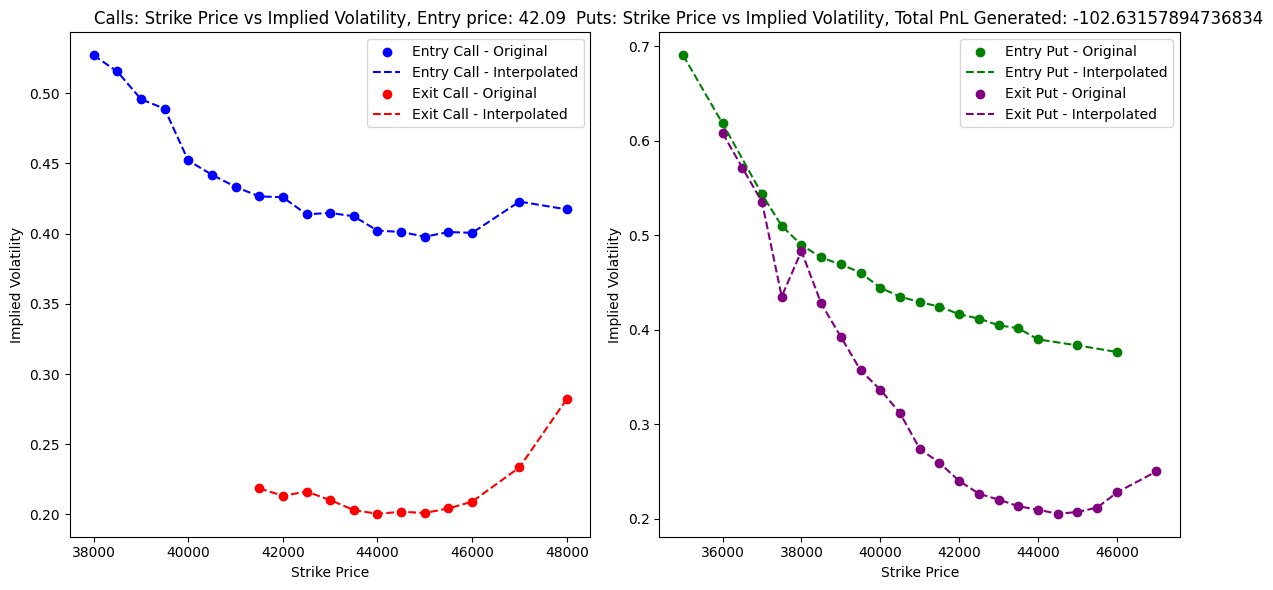

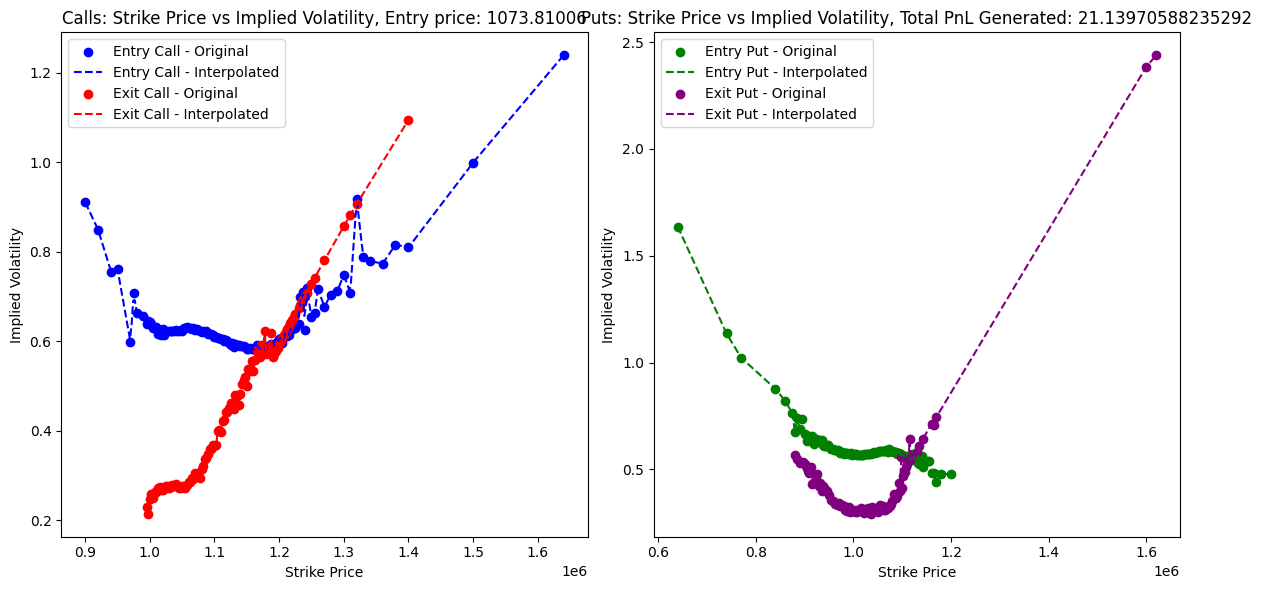

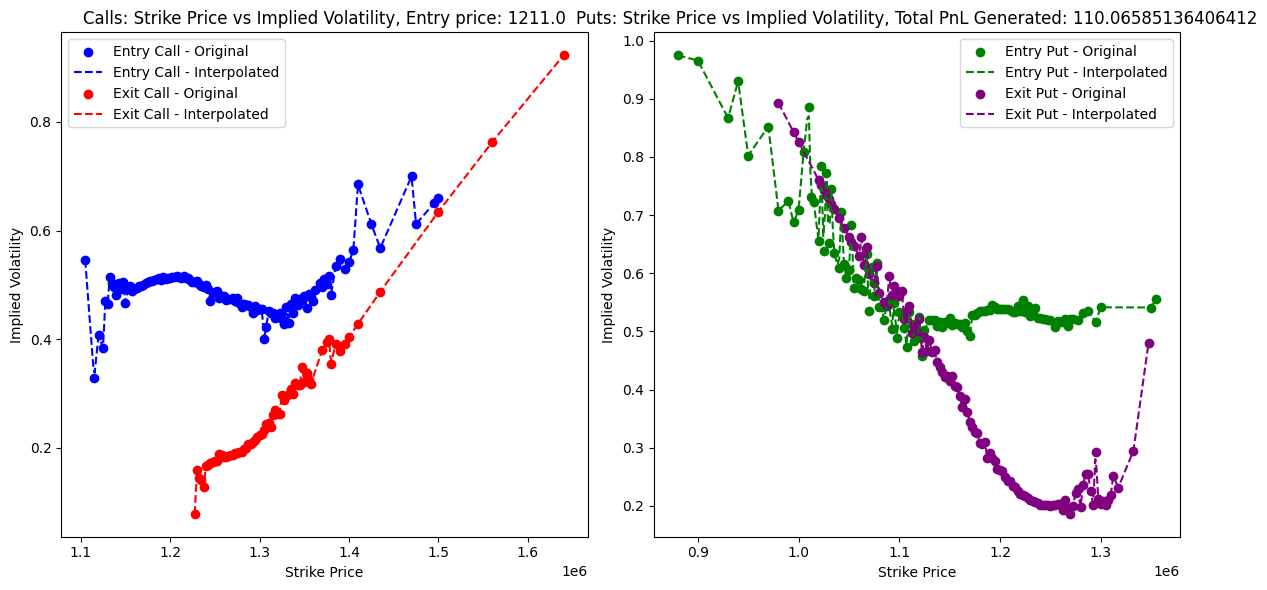

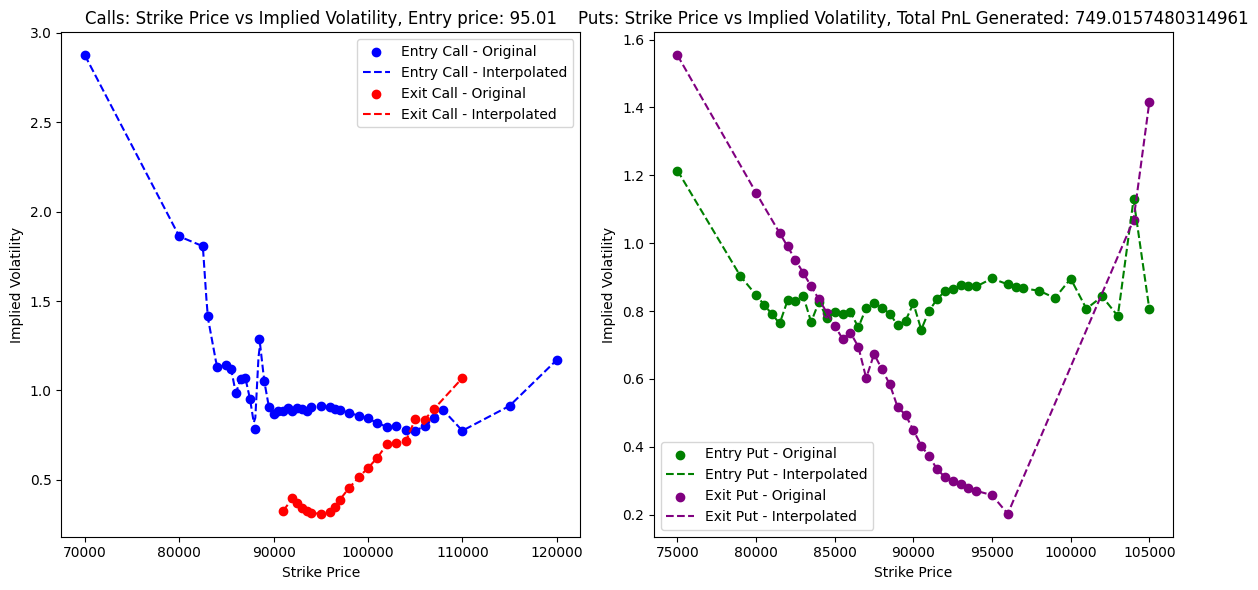

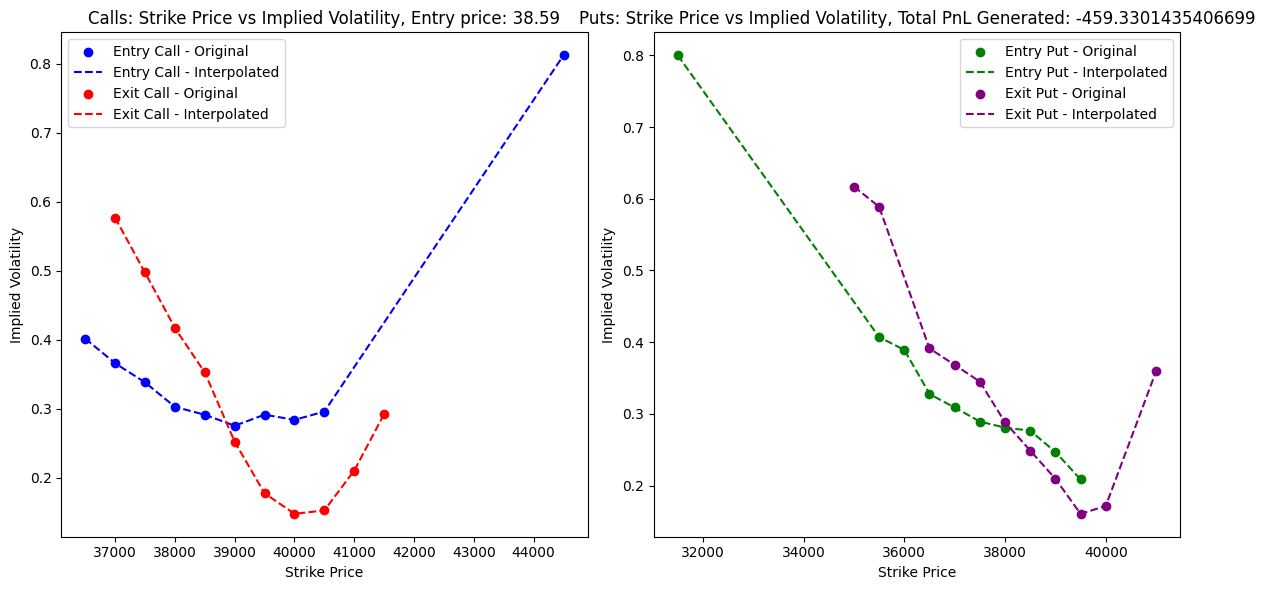

In [41]:
for i in range(5):
    ex_date_entry=options_dict_large[2018][(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_entry'][i])]['exdate'].min()
    ex_date_exit=options_dict_large[2018][(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_exit'][i])]['exdate'].min()
    tmp_entry_call=options_dict_large[2018][(options_dict_large[2018]['exdate']==ex_date_entry) &(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_entry'][i]) & (options_dict_large[2018]['cp_flag']=='C')]
    tmp_exit_call=options_dict_large[2018][(options_dict_large[2018]['exdate']==ex_date_entry) &(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_exit'][i]) & (options_dict_large[2018]['cp_flag']=='C')]
    tmp_entry_put=options_dict_large[2018][(options_dict_large[2018]['exdate']==ex_date_exit) &(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_entry'][i]) & (options_dict_large[2018]['cp_flag']=='P')]
    tmp_exit_put=options_dict_large[2018][(options_dict_large[2018]['exdate']==ex_date_exit) &(options_dict_large[2018]['ticker']==data_2018_large['Short_ticker'][i]) & (options_dict_large[2018]['date']==data_2018_large['trade_exit'][i]) & (options_dict_large[2018]['cp_flag']=='P')]
    # Set the size of the entire figure
    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Plot for Calls
    ax1 = plt.subplot(1, 2, 1)
    plot_with_interpolation(tmp_entry_call, ax1, 'Entry Call', 'blue')
    plot_with_interpolation(tmp_exit_call, ax1, 'Exit Call', 'red')
    ax1.set_title(f'Calls: Strike Price vs Implied Volatility, Entry price: {data_2018_large['stock_price_entry'][i]}')
    ax1.set_xlabel('Strike Price')
    ax1.set_ylabel('Implied Volatility')
    ax1.legend()

    # Plot for Puts
    ax2 = plt.subplot(1, 2, 2)
    plot_with_interpolation(tmp_entry_put, ax2, 'Entry Put', 'green')
    plot_with_interpolation(tmp_exit_put, ax2, 'Exit Put', 'purple')
    ax2.set_title(f'Puts: Strike Price vs Implied Volatility, Total PnL Generated: {data_2018_large['straddle_pnl'][i]}')
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Implied Volatility')
    ax2.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

### Mid Cap

In [42]:
data_2018_mid=merged_df_mkt[merged_df_mkt['mkt_cap']=='Mid Cap']
data_2018_mid.reset_index(inplace=True)

In [43]:
dates=list(data_2018_mid['trade_entry'][0:5])+(list(data_2018_mid['trade_exit'][0:5]))
date_str = ', '.join(f"'{date}'" for date in dates)

In [44]:

options_dict_mid = {} 
for year in range(2018, 2019):
    table_name = f"optionm.opprcd{year}"  # Generate table name dynamically
    query = f"""
    SELECT
        date,  symbol, cp_flag, strike_price, exdate,  impl_volatility
    FROM 
        {table_name} a 
    WHERE
    
        a.volume > 0 AND
        a.expiry_indicator = 'w' AND
        a.date IN ({date_str})
    """
    options_dict_mid[year] = db.raw_sql(query, date_cols=['date'])

In [45]:
options_dict_mid[2018]['ticker']=options_dict_mid[2018]['symbol'].apply(lambda x: x.split(' ')[0])
options_dict_mid[2018]=options_dict_mid[2018][options_dict_mid[2018]['ticker'].isin(data_2018_mid['Short_ticker'])]
options_dict_mid[2018].dropna(subset='impl_volatility',inplace=True)

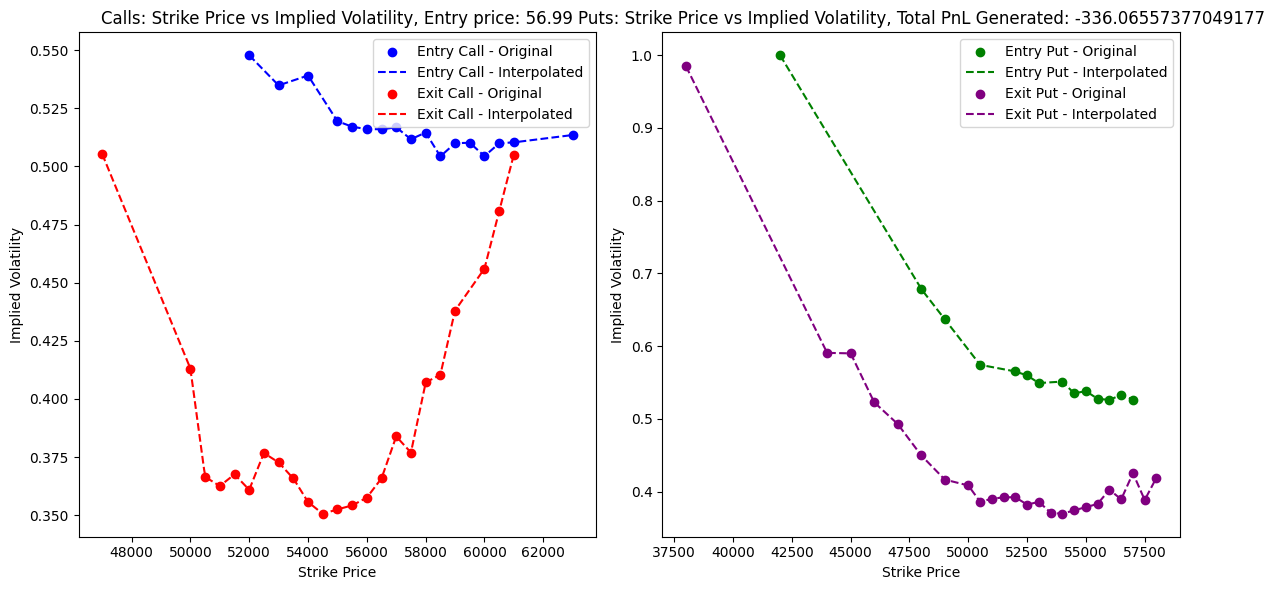

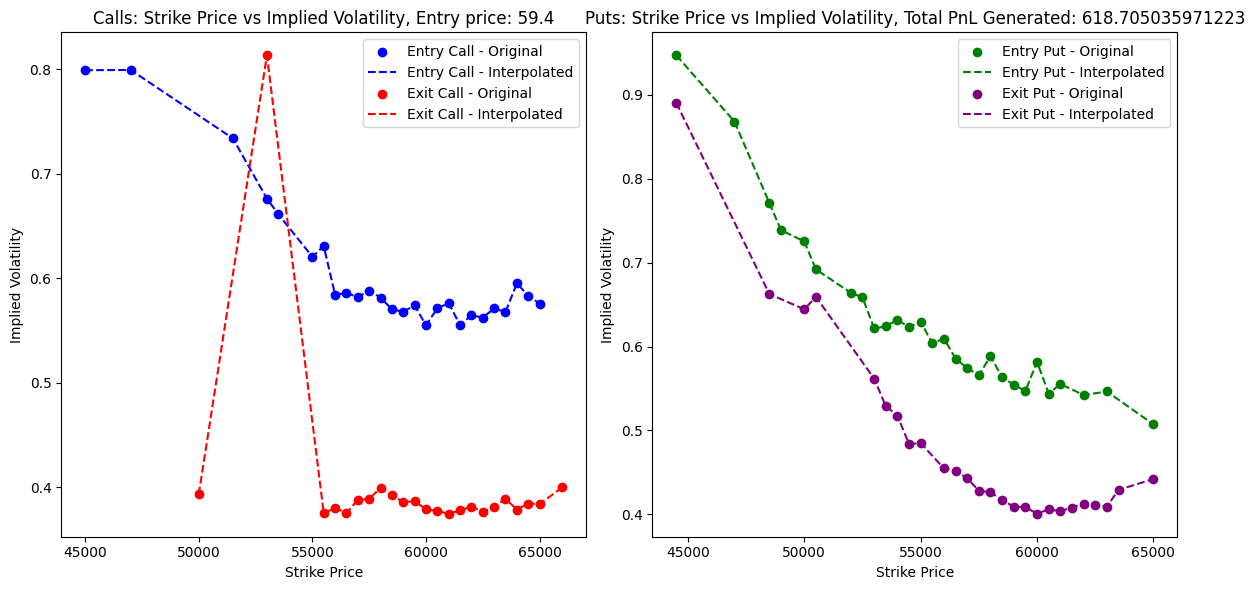

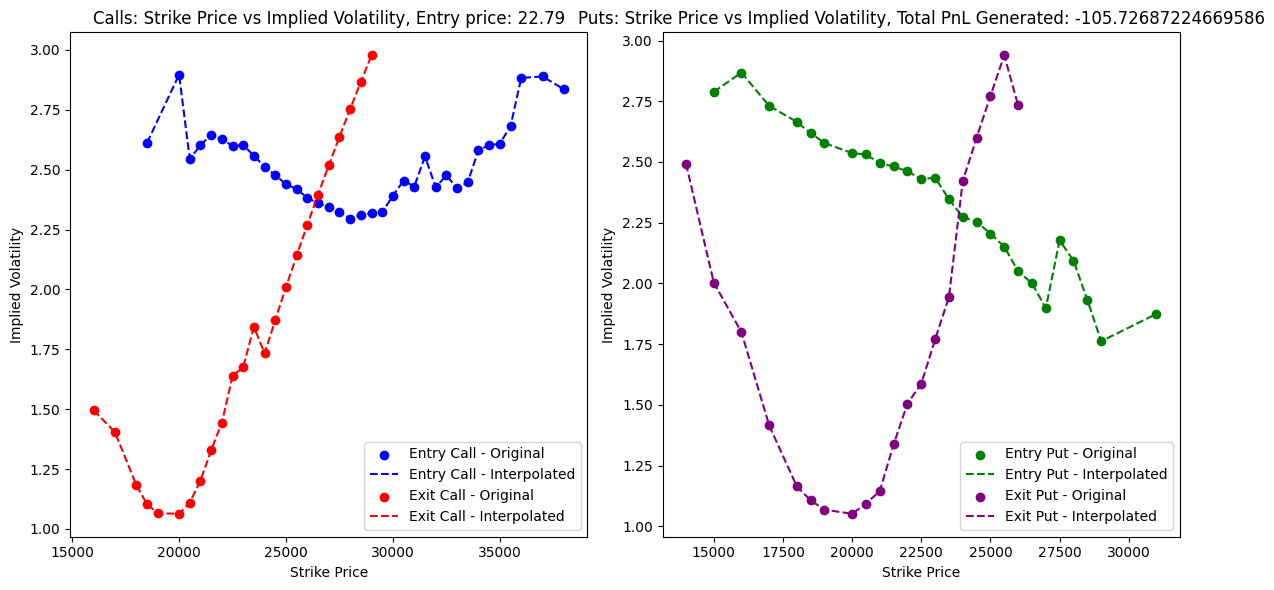

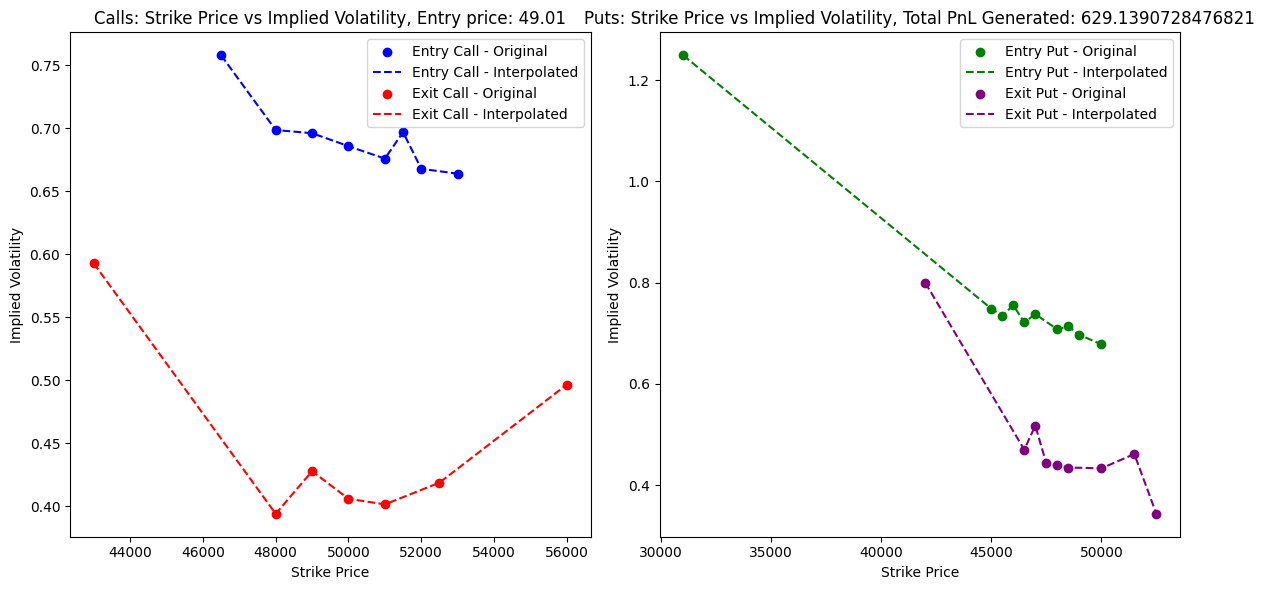

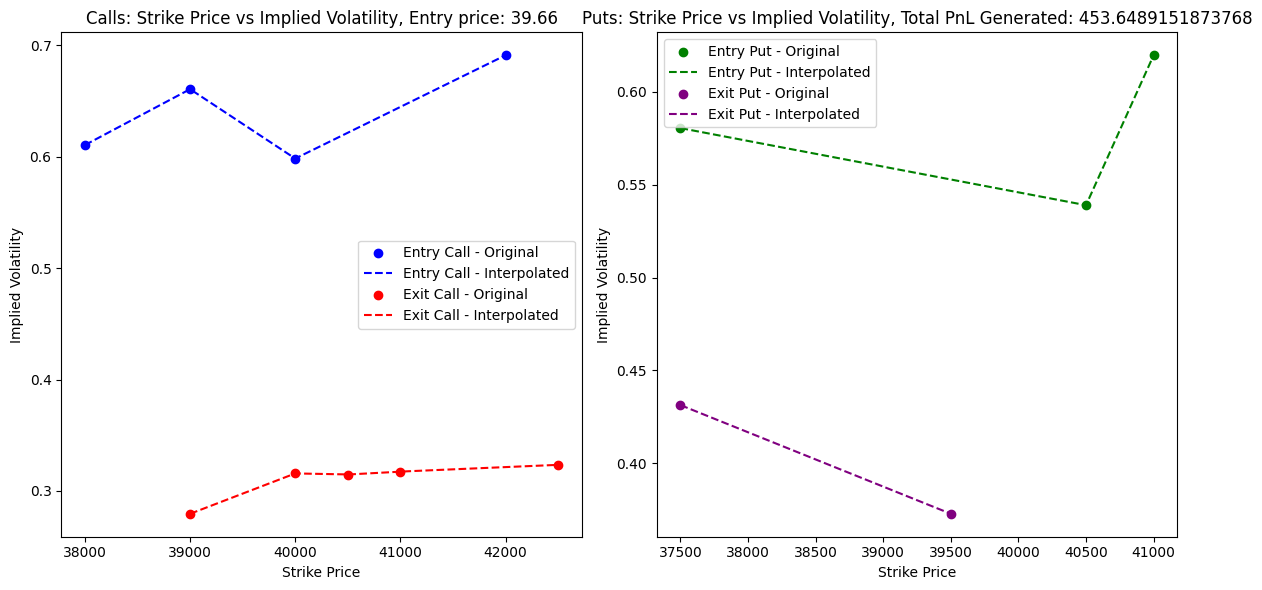

In [46]:
for i in range(5):
    ex_date_entry=options_dict_mid[2018][(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_entry'][i])]['exdate'].min()
    ex_date_exit=options_dict_mid[2018][(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_exit'][i])]['exdate'].min()
    tmp_entry_call=options_dict_mid[2018][(options_dict_mid[2018]['exdate']==ex_date_entry) &(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_entry'][i]) & (options_dict_mid[2018]['cp_flag']=='C')]
    tmp_exit_call=options_dict_mid[2018][(options_dict_mid[2018]['exdate']==ex_date_entry) &(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_exit'][i]) & (options_dict_mid[2018]['cp_flag']=='C')]
    tmp_entry_put=options_dict_mid[2018][(options_dict_mid[2018]['exdate']==ex_date_exit) &(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_entry'][i]) & (options_dict_mid[2018]['cp_flag']=='P')]
    tmp_exit_put=options_dict_mid[2018][(options_dict_mid[2018]['exdate']==ex_date_exit) &(options_dict_mid[2018]['ticker']==data_2018_mid['Short_ticker'][i]) & (options_dict_mid[2018]['date']==data_2018_mid['trade_exit'][i]) & (options_dict_mid[2018]['cp_flag']=='P')]
    # Set the size of the entire figure
    # Set up the figure
    plt.figure(figsize=(12, 6))

    # Plot for Calls
    ax1 = plt.subplot(1, 2, 1)
    plot_with_interpolation(tmp_entry_call, ax1, 'Entry Call', 'blue')
    plot_with_interpolation(tmp_exit_call, ax1, 'Exit Call', 'red')
    ax1.set_title(f'Calls: Strike Price vs Implied Volatility, Entry price: {data_2018_mid['stock_price_entry'][i]}')
    ax1.set_xlabel('Strike Price')
    ax1.set_ylabel('Implied Volatility')
    ax1.legend()

    # Plot for Puts
    ax2 = plt.subplot(1, 2, 2)
    plot_with_interpolation(tmp_entry_put, ax2, 'Entry Put', 'green')
    plot_with_interpolation(tmp_exit_put, ax2, 'Exit Put', 'purple')
    ax2.set_title(f'Puts: Strike Price vs Implied Volatility, Total PnL Generated: {data_2018_mid['straddle_pnl'][i]}')
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Implied Volatility')
    ax2.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()